# PROJ NAVIA

**Implemented by:**

*Akshay Suresh - 120981975*

*Mukul Rayana - 121330918*

*Srutileka Suresh - 121146359*

## Libraries & Setup

In [ ]:
!pip install osmnx folium networkx geopy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 1.9 MB/s eta 0:00:00


In [ ]:
import osmnx as ox
import networkx as nx
import folium
import random
from math import radians, cos, sin, asin, sqrt
import matplotlib.pyplot as plt
from google.colab import drive
from os.path import exists
import time

## Gdrive

In [ ]:
drive.mount('/content/drive')
graph_path = "/content/drive/MyDrive/dc_graph.graphml"

if exists(graph_path):
    G = ox.load_graphml(graph_path)
else:
    G = ox.graph_from_place("Washington, D.C., USA", network_type='drive')
    ox.save_graphml(G, graph_path)

Mounted at /content/drive


## Haversine Function

In [ ]:
def haversine_distance(n1, n2, G):
    lat1 = float(G.nodes[n1]['y'])
    lon1 = float(G.nodes[n1]['x'])
    lat2 = float(G.nodes[n2]['y'])
    lon2 = float(G.nodes[n2]['x'])
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    return 6371 * 1000 * c

## Hardcoded Landmarks

In [ ]:
coords = {
    "The White House": (38.8976997, -77.0365532),
    "U.S. Capitol Building": (38.8716043, -77.0057659),
    "Lincoln Memorial": (38.890288, -77.0500718),
    "Washington Monument": (38.889865, -77.033036),
    "MLK Jr. Memorial": (38.889395, -77.040308),
    "Smithsonian Natural History": (38.8919309, -77.0259904),
    "National Air and Space Museum": (38.8871903, -77.0208887),
    "Library of Congress": (38.8867409, -77.0047055),
    "National Gallery of Art": (38.8920825, -77.0226804),
    "Union Station": (38.897073, -77.006414),
    "Washington National Cathedral": (38.930614, -77.071816),
    "Dupont Circle": (38.909641, -77.043149),
    "Adams Morgan": (38.921294, -77.042141),
    "Eastern Market": (38.884003, -76.996999),
    "Foggy Bottom": (38.900772, -77.051853),
    "Navy Yard": (38.876014, -77.003759),
    "Georgetown Waterfront": (38.902946, -77.061182),
    "Ronald Reagan Building": (38.894265, -77.028023)
}

## User input for Locations

In [ ]:
print("Select Start and End Landmarks:")
places = list(coords.keys())
for i, name in enumerate(places):
    print(f"{i+1}. {name}")
start = int(input("Start (number): ")) - 1
end = int(input("End (number): ")) - 1

start_coords = coords[places[start]]
end_coords = coords[places[end]]
orig = ox.distance.nearest_nodes(G, X=start_coords[1], Y=start_coords[0])
dest = ox.distance.nearest_nodes(G, X=end_coords[1], Y=end_coords[0])

Select Start and End Landmarks:
1. The White House
2. U.S. Capitol Building
3. Lincoln Memorial
4. Washington Monument
5. MLK Jr. Memorial
6. Smithsonian Natural History
7. National Air and Space Museum
8. Library of Congress
9. National Gallery of Art
10. Union Station
11. Washington National Cathedral
12. Dupont Circle
13. Adams Morgan
14. Eastern Market
15. Foggy Bottom
16. Navy Yard
17. Georgetown Waterfront
18. Ronald Reagan Building
Start (number): 15
End (number): 6


## Dijkstra & A* Star Algorithm

In [ ]:
dijkstra_path = nx.shortest_path(G, orig, dest, weight='length')
a_star_path = nx.astar_path(G, orig, dest, heuristic=lambda u, v: haversine_distance(u, v, G), weight='length')

## Map Render

In [ ]:
m_before = folium.Map(location=start_coords, zoom_start=14)

# Start & End Markers
folium.Marker(start_coords, tooltip="Start", icon=folium.Icon(color='green')).add_to(m_before)
folium.Marker(end_coords, tooltip="End", icon=folium.Icon(color='red')).add_to(m_before)

# Slight offset
offset_coords = [(G.nodes[n]['y'] + 0.0001, G.nodes[n]['x'] + 0.0001) for n in dijkstra_path]

folium.PolyLine(
    offset_coords,
    color='blue', weight=4, dash_array='5', tooltip="Dijkstra Path"
).add_to(m_before)

# A* Route - solid green
folium.PolyLine(
    [(G.nodes[n]['y'], G.nodes[n]['x']) for n in a_star_path],
    color='green', weight=4, tooltip="A* Path"
).add_to(m_before)

from branca.element import Template, MacroElement

legend_html = """
{% macro html(this, kwargs) %}

<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 180px;
    height: 95px;
    background-color: white;
    border:2px solid grey;
    z-index:9999;
    font-size:14px;
    box-shadow: 2px 2px 6px rgba(0,0,0,0.3);
    padding: 10px;
">
<b>Route Legend</b><br>
<span style="color:blue;">&#9632;</span> Dijkstra (Offset Dashed)<br>
<span style="color:green;">&#9632;</span> A* (Original Path)
</div>

{% endmacro %}
"""

legend = MacroElement()
legend._template = Template(legend_html)
m_before.get_root().add_child(legend)

m_before.save('/content/drive/MyDrive/dc_route_map_before_blockage.html')
m_before

## OPTIONAL MANUAL BLOCK

In [ ]:
print("\n-- Optional Roadblock Selection --")
blocked_edges = []
for i, (u, v) in enumerate(zip(dijkstra_path[:-1], dijkstra_path[1:])):
    name = G.edges[u, v, 0].get('name', 'Unnamed Road')
    print(f"{i+1}. {u} ↔ {v} | {name}")
if input("Block road(s)? (y/n): ") == 'y':
    block_input = input("Enter edge numbers to block (comma-separated): ")
    indices = [int(i.strip()) - 1 for i in block_input.split(',') if i.strip().isdigit()]
    for idx in indices:
        edge = (dijkstra_path[idx], dijkstra_path[idx + 1])
        if G.has_edge(*edge):
            blocked_edges.append(edge)
            G.remove_edge(*edge)


-- Optional Roadblock Selection --
1. 2462383188 ↔ 49787740 | I Street Northwest
2. 49787740 ↔ 49777724 | 24th Street Northwest
3. 49777724 ↔ 49777712 | H Street Northwest
4. 49777712 ↔ 49762286 | 23rd Street Northwest
5. 49762286 ↔ 262542282 | 23rd Street Northwest
6. 262542282 ↔ 641127587 | 23rd Street Northwest
7. 641127587 ↔ 641127594 | 23rd Street Northwest
8. 641127594 ↔ 9622473645 | Virginia Avenue Northwest
9. 9622473645 ↔ 49730319 | Virginia Avenue Northwest
10. 49730319 ↔ 49782077 | Virginia Avenue Northwest
11. 49782077 ↔ 49767076 | Virginia Avenue Northwest
12. 49767076 ↔ 49741663 | Virginia Avenue Northwest
13. 49741663 ↔ 4001510836 | Virginia Avenue Northwest
14. 4001510836 ↔ 3008009375 | Virginia Avenue Northwest
15. 3008009375 ↔ 641127601 | Virginia Avenue Northwest
16. 641127601 ↔ 11260344012 | Virginia Avenue Northwest
17. 11260344012 ↔ 49748779 | 19th Street Northwest
18. 49748779 ↔ 647584811 | Constitution Avenue Northwest
19. 647584811 ↔ 49748775 | Constitution Av

## RERUN PATHFINDING

In [ ]:
t0 = time.time()
dijkstra_path = nx.shortest_path(G, orig, dest, weight='length')
dijkstra_time = time.time() - t0

start_astar = time.time()
a_star_path = nx.astar_path(G, orig, dest, heuristic=lambda u, v: haversine_distance(u, v, G), weight='length')
a_star_time = time.time() - start_astar

## METRICS + VISUALIZATION

In [ ]:
dijkstra_len = nx.path_weight(G, dijkstra_path, weight='length')
a_star_len = nx.path_weight(G, a_star_path, weight='length')

print("\n--- Route Metrics ---")
print(f"Dijkstra: {dijkstra_len:.2f}m | {dijkstra_time:.4f}s")
print(f"A*      : {a_star_len:.2f}m | {a_star_time:.4f}s")


--- Route Metrics ---
Dijkstra: 3026.92m | 0.0127s
A*      : 3026.92m | 0.0041s


## MAP RENDERING - ROAD BLOCKAGES

In [ ]:
m = folium.Map(location=start_coords, zoom_start=14)
folium.Marker(start_coords, tooltip="Start", icon=folium.Icon(color='green')).add_to(m)
folium.Marker(end_coords, tooltip="End", icon=folium.Icon(color='red')).add_to(m)
folium.PolyLine([(G.nodes[n]['y'], G.nodes[n]['x']) for n in dijkstra_path], color='blue', weight=4, tooltip="Dijkstra Path").add_to(m)
folium.PolyLine([(G.nodes[n]['y'], G.nodes[n]['x']) for n in a_star_path], color='green', weight=4, tooltip="A* Path").add_to(m)
for u, v in blocked_edges:
    loc1 = (G.nodes[u]['y'], G.nodes[u]['x'])
    loc2 = (G.nodes[v]['y'], G.nodes[v]['x'])
    folium.Marker(loc1, icon=folium.Icon(color='orange', icon='remove-sign')).add_to(m)
    folium.Marker(loc2, icon=folium.Icon(color='orange', icon='remove-sign')).add_to(m)
    folium.PolyLine([loc1, loc2], color='black', dash_array='5').add_to(m)
m.save('/content/drive/MyDrive/dc_route_map.html')
m

## SUMMARY RESULTS

In [ ]:
dijkstra_nodes = list(nx.shortest_path_length(G, source=orig, weight='length').keys())
a_star_nodes = set(a_star_path)  # simple proxy

print("\n==============================")
print("🔍 Algorithm Summary")
print("==============================")
print("| Algorithm | Time Complexity       | Space Complexity | Distance (m)  | Runtime (s)   |")
print("|-----------|-----------------------|------------------|---------------|--------------|")
print(f"| Dijkstra  | O((V + E) log V)      | O(V)             | {dijkstra_len:.2f}       | {dijkstra_time:.4f}       |")
print(f"| A*        | O((V + E) log V) + h  | O(V)             | {a_star_len:.2f}       | {a_star_time:.4f}       |")
print("| Heuristic | Haversine Distance    | -                | -             | -            |")
print(f"| Blocks    | -                     | -                | -             | {len(blocked_edges)} roadblock(s) |")
print("==============================")


🔍 Algorithm Summary
| Algorithm | Time Complexity       | Space Complexity | Distance (m)  | Runtime (s)   |
|-----------|-----------------------|------------------|---------------|--------------|
| Dijkstra  | O((V + E) log V)      | O(V)             | 3026.92       | 0.0127       |
| A*        | O((V + E) log V) + h  | O(V)             | 3026.92       | 0.0041       |
| Heuristic | Haversine Distance    | -                | -             | -            |
| Blocks    | -                     | -                | -             | 8 roadblock(s) |


## Nodes Traversed

In [ ]:
dijkstra_visited = list(nx.shortest_path_length(G, source=orig, weight='length').keys())
a_star_visited = set(a_star_path)  # Use nodes in actual A* path as proxy


print(f"🟦 Dijkstra visited nodes: {len(dijkstra_visited)}")
print(f"🟩 A* estimated nodes:     {len(a_star_visited)}")

🟦 Dijkstra visited nodes: 9944
🟩 A* estimated nodes:     26


## CHART VISUALIZATION

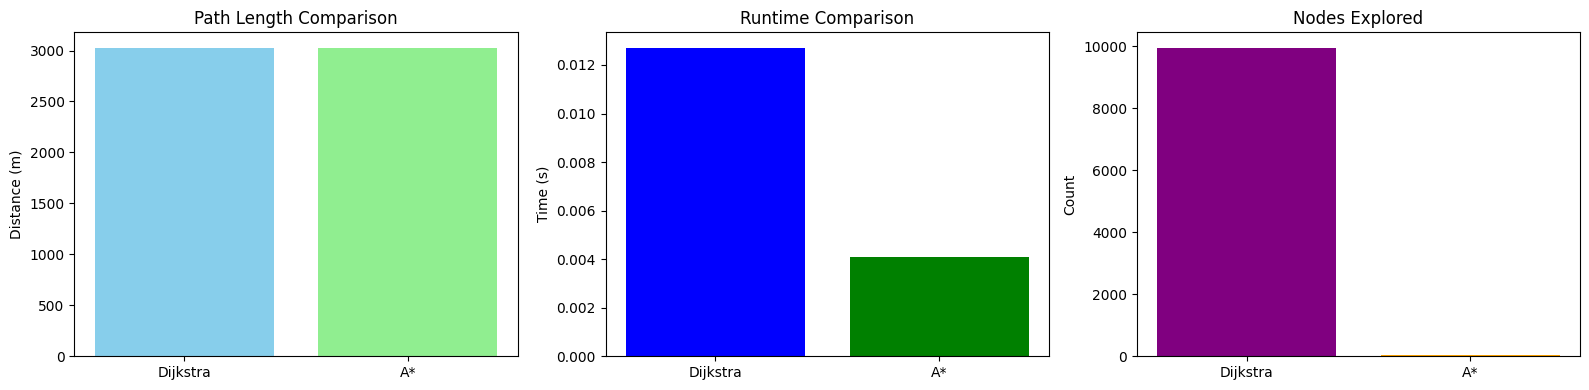

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].bar(['Dijkstra', 'A*'], [dijkstra_len, a_star_len], color=['skyblue', 'lightgreen'])
axs[0].set_title('Path Length Comparison')
axs[0].set_ylabel('Distance (m)')
axs[1].bar(['Dijkstra', 'A*'], [dijkstra_time, a_star_time], color=['blue', 'green'])
axs[1].set_title('Runtime Comparison')
axs[1].set_ylabel('Time (s)')
axs[2].bar(['Dijkstra', 'A*'], [len(dijkstra_nodes), len(a_star_nodes)], color=['purple', 'orange'])
axs[2].set_title('Nodes Explored')
axs[2].set_ylabel('Count')
plt.tight_layout()
plt.show()

## CONCLUSION

In [ ]:
print("\n💡 Conclusion:")
if dijkstra_time < a_star_time:
    print("Dijkstra performed faster in this instance, despite exploring more nodes.")
elif a_star_time < dijkstra_time:
    print("A* outperformed Dijkstra by reducing unnecessary node visits via its heuristic.")
else:
    print("Both algorithms performed equally on this route.")


💡 Conclusion:
A* outperformed Dijkstra by reducing unnecessary node visits via its heuristic.
